In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class ActorDiscrete(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(ActorDiscrete, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, a_dim))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        out= F.softmax(out+1e-10, dim=-1)
        return out
    
    def sampling(self, state):

        probs = self(state)
        dist = Categorical(probs)
        sampled_actions = dist.sample()
        log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
        return probs, log_probs


In [4]:
class V_function(nn.Module):
    def __init__(self, s_dim, hidden_dim=256, num_hidden_layers=2):
        super(V_function, self).__init__()

        self.s_dim = s_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        out = self.f(state)
        return out

In [5]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        #print(state.shape, action.unsqueeze(1).shape)
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [6]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [7]:
class Buffer:
    def __init__(self, s_dim, a_dim, buffer_capacity=int(1e6)):
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.buffer_capacity = buffer_capacity
        self.size = 0
        self.pointer = 0

        self.states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_capacity, a_dim), dtype=np.float32)
        self.rewards = np.zeros((buffer_capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.dones = np.zeros((buffer_capacity, 1), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        self.states[self.pointer] = state
        self.actions[self.pointer] = action
        self.rewards[self.pointer] = reward
        self.next_states[self.pointer] = next_state
        self.dones[self.pointer] = done

        self.pointer = (self.pointer + 1) % self.buffer_capacity
        if self.size < self.buffer_capacity:
            self.size += 1

    def sample_batch(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        states = torch.FloatTensor(self.states[idxs])
        actions = torch.LongTensor(self.actions[idxs])
        rewards = torch.FloatTensor(self.rewards[idxs])
        next_states = torch.FloatTensor(self.next_states[idxs])
        dones = torch.FloatTensor(self.dones[idxs])
        return states, actions, rewards, next_states, dones

In [8]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, hidden_dim_value=256, 
                 num_layer_value = 2,lr_act=3e-4, lr_crit=3e-4, lr_value = 3e-4,
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, step_size_scheduler=10000, 
                 gamma_scheduler=1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = Buffer(s_dim, a_dim, buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = ActorDiscrete(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.value = V_function(s_dim, hidden_dim_value, num_hidden_layers=num_layer_value).to(device)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=lr_value)

        self.value_target = copy.deepcopy(self.value).to(device)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=step_size_scheduler, gamma=gamma_scheduler)
        self.critic_scheduler = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=step_size_scheduler, gamma=gamma_scheduler)
        self.value_scheduler = optim.lr_scheduler.StepLR(self.value_optimizer, step_size=step_size_scheduler, gamma=gamma_scheduler)

    def choose_action(self, state):
        self.actor.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs, _ = self.actor.sampling(state.to(self.device))
            dist = Categorical(action_probs)
            action = dist.sample()
        return action.item(), action_probs.squeeze().detach().cpu().numpy()

    def train(self, update_interval):
        critic_loss, actor_loss, value_loss = 0, 0, 0
        if self.buffer.size < self.batch_size:
            
            states, actions, rewards, next_states, dones = self.buffer.sample_batch(self.buffer.size)
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)
            # Train V function
            value_loss = self.value_train(states)

            # Critic train
            critic_loss = self.critic_train(states, actions, next_states, rewards, dones)

            # Actor train
            actor_loss=self.train_actor(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_param, param in zip(self.value_target.parameters(), self.value.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            
            
            return None, None, None

        for i in range(self.grad_steps):
            states, actions, rewards, next_states, dones = self.buffer.sample_batch(self.batch_size)
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)
            # Train V function
            value_loss = self.value_train(states)

            # Critic train
            critic_loss = self.critic_train(states, actions, next_states, rewards, dones)

            # Actor train
            actor_loss=self.train_actor(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_param, param in zip(self.value_target.parameters(), self.value.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        return critic_loss, actor_loss, value_loss
    
    def value_train(self, states):
        probs, actions_log_probs = self.actor.sampling(states)

        with torch.no_grad():
            q1, q2 = self.critic(states, probs)
            min_q = torch.min(q1, q2) - self.alpha * actions_log_probs

        value = self.value(states)
        value_target = min_q
        value_loss = F.mse_loss(value, value_target)

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        self.value_scheduler.step()

        return value_loss.item()
    
    def critic_train(self, states, actions, next_states, rewards, dones):
        with torch.no_grad():
            next_value = self.value_target(next_states)
            target_q_value = rewards + self.gamma * (1 - dones) * next_value

        q1, q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic_scheduler.step()

        return critic_loss.item()
    
    def train_actor(self, states):
        probs, log_probs = self.actor.sampling(states)
        q1_actor, q2_actor = self.critic(states, probs)
        min_q_actor = torch.min(q1_actor, q2_actor)

        actor_loss = (self.alpha * log_probs - min_q_actor).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_scheduler.step()

        return actor_loss.item()

    def add_elements_to_buffer(self, state, probs, reward, next_state, done):
        self.buffer.add(state, probs, reward, next_state, done)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

In [11]:
def train_SAC(agent, env, n_games, training_interval=1, update_interval=1, print_num_episodes=10):
    env.seed(0)
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval


    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, probs = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.add_elements_to_buffer(observation, probs, reward, observation_, done)
            observation = observation_
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                critic_loss, actor_loss, value_loss = agent.train(update_interval)

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            #print(critic_loss, actor_loss, value_loss)
    
    env.close()

    return score_history

## Cartpole-v0

In [12]:
env = gym.make("CartPole-v0")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=2, num_layer_critic=2, lr_act=5e-4, lr_crit=5e-4, alpha=0.25, tau=0.5, batch_size=16, 
            grad_steps=2, device=device)

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=5)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\envs\registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:268: DeprecationWar

episode 0 score 69.0 avg score 69.0
episode 5 score 9.0 avg score 20.2
episode 10 score 11.0 avg score 17.3
episode 15 score 11.0 avg score 15.5
episode 20 score 12.0 avg score 14.6
episode 25 score 9.0 avg score 13.5
episode 30 score 9.0 avg score 13.3
episode 35 score 10.0 avg score 12.9
episode 40 score 10.0 avg score 12.6
episode 45 score 11.0 avg score 12.3
episode 50 score 9.0 avg score 12.0
episode 55 score 11.0 avg score 11.8
episode 60 score 9.0 avg score 11.6
episode 65 score 9.0 avg score 11.5
episode 70 score 8.0 avg score 11.3
episode 75 score 10.0 avg score 11.2
episode 80 score 9.0 avg score 11.0
episode 85 score 9.0 avg score 11.0
episode 90 score 10.0 avg score 10.9
episode 95 score 9.0 avg score 10.8
episode 100 score 11.0 avg score 10.2
episode 105 score 9.0 avg score 10.1


KeyboardInterrupt: 

In [1]:
import csv

# Provided data
data = """
episode 0 score 20.0 avg score 20.0
episode 5 score 9.0 avg score 17.8
episode 10 score 10.0 avg score 16.1
episode 15 score 8.0 avg score 13.9
episode 20 score 10.0 avg score 12.9
episode 25 score 37.0 avg score 13.4
episode 30 score 42.0 avg score 19.3
episode 35 score 121.0 avg score 29.6
episode 40 score 184.0 avg score 44.1
episode 45 score 200.0 avg score 61.0
episode 50 score 200.0 avg score 74.7
episode 55 score 200.0 avg score 85.9
episode 60 score 200.0 avg score 95.2
episode 65 score 200.0 avg score 103.2
episode 70 score 200.0 avg score 110.0
episode 75 score 200.0 avg score 115.9
episode 80 score 200.0 avg score 121.1
episode 85 score 200.0 avg score 125.7
episode 90 score 200.0 avg score 129.8
episode 95 score 200.0 avg score 133.4
episode 100 score 200.0 avg score 137.9
episode 105 score 200.0 avg score 147.0
episode 110 score 200.0 avg score 156.3
episode 115 score 200.0 avg score 165.9
episode 120 score 200.0 avg score 175.4
episode 125 score 200.0 avg score 184.6
episode 130 score 200.0 avg score 192.1
episode 135 score 200.0 avg score 197.4
episode 140 score 200.0 avg score 200.0
episode 145 score 200.0 avg score 200.0
episode 150 score 200.0 avg score 200.0
episode 155 score 200.0 avg score 200.0
episode 160 score 200.0 avg score 199.4
episode 165 score 200.0 avg score 198.1
episode 170 score 200.0 avg score 198.1
episode 175 score 200.0 avg score 198.1
episode 180 score 200.0 avg score 198.1
episode 185 score 200.0 avg score 198.1
episode 190 score 200.0 avg score 197.9
episode 195 score 200.0 avg score 197.9
"""

# Extract scores from the provided data
lines = data.strip().split('\n')
scores = []

for line in lines:
    parts = line.split()
    score_index = parts.index('score') + 1
    scores.append(parts[score_index])

# Write scores to a CSV file
with open('cartpole1_sac_scores.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['score'])
    for score in scores:
        writer.writerow([score])

print("Scores have been written to scores.csv")

Scores have been written to scores.csv


## Cartpole-v1

episode 0 score 14.0 avg score 14.0
episode 5 score 17.0 avg score 15.0
episode 10 score 28.0 avg score 16.5
episode 15 score 15.0 avg score 18.1
episode 20 score 106.0 avg score 26.8
episode 25 score 141.0 avg score 41.5
episode 30 score 97.0 avg score 56.9
episode 35 score 194.0 avg score 69.2
episode 40 score 163.0 avg score 86.1
episode 45 score 256.0 avg score 97.1
episode 50 score 273.0 avg score 108.2
episode 55 score 277.0 avg score 119.4
episode 60 score 280.0 avg score 131.1
episode 65 score 256.0 avg score 138.6
episode 70 score 356.0 avg score 152.9
episode 75 score 204.0 avg score 166.1
episode 80 score 417.0 avg score 182.5
episode 85 score 500.0 avg score 197.4
episode 90 score 500.0 avg score 207.4
episode 95 score 500.0 avg score 222.4
episode 100 score 317.0 avg score 236.6
episode 105 score 500.0 avg score 260.8
episode 110 score 500.0 avg score 284.9
episode 115 score 500.0 avg score 308.8
episode 120 score 500.0 avg score 331.1
episode 125 score 500.0 avg score 350

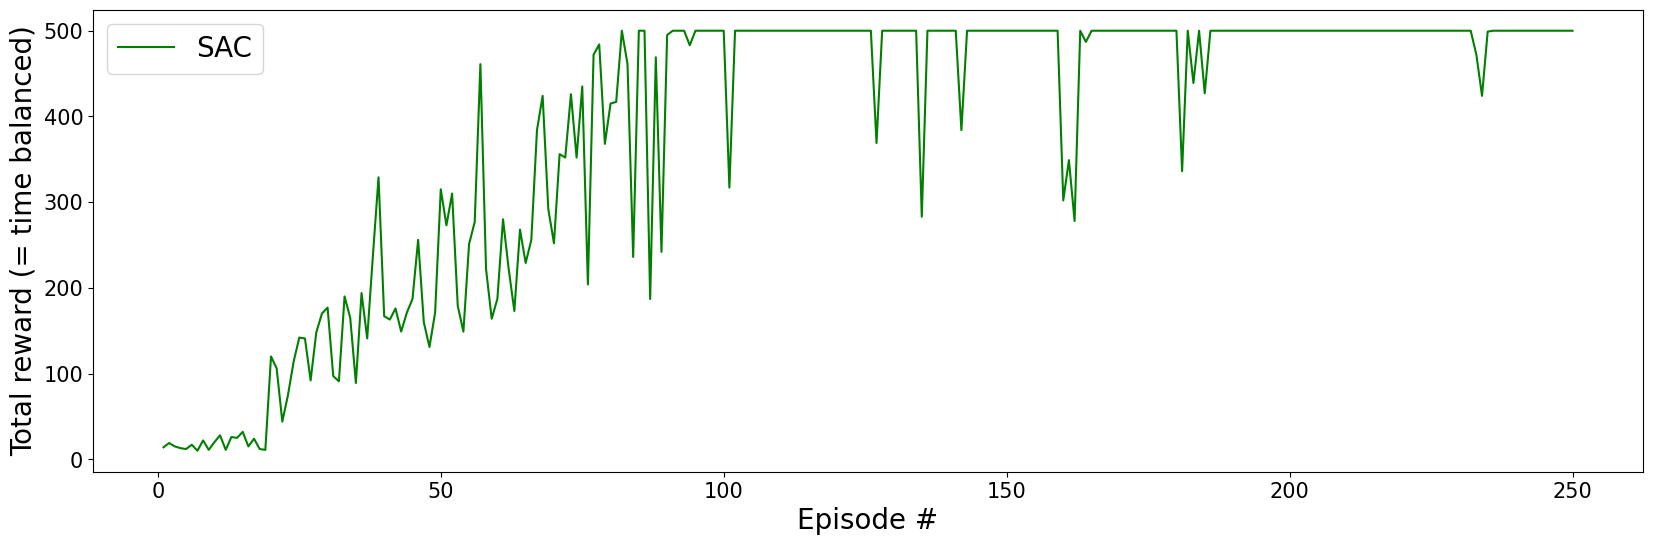

In [129]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.05, batch_size=32, 
            grad_steps=10, device=device)

score_history = train_SAC(agent, env, 250, training_interval=2, update_interval=1, print_num_episodes=5)
plot_scores(score_history)

## MountainCar-v0:

In [31]:
env = gym.make("MountainCar-v0")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 128, hidden_dim_critic=128, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.05, batch_size=64, 
            grad_steps=2, device=device)

score_history = train_SAC(agent, env, 300, training_interval=1, update_interval=1, print_num_episodes=10)
plot_scores(score_history)

0


AttributeError: 'SAC' object has no attribute 'replay_buffer'

In [28]:
env = gym.make("MountainCar-v0")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-3, lr_crit=3e-3, alpha=0.2, tau=0.05, batch_size=256, 
            grad_steps=1, device=device)

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=10)
plot_scores(score_history)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Acrobot-v1

In [22]:
env = gym.make("Acrobot-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(5e5), hidden_dim_actor = 128, hidden_dim_critic=128, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, alpha=0.25, tau=0.01, batch_size=64, 
            grad_steps=2, device=device)

score_history = train_SAC(agent, env, 100, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


NotImplementedError: 